In [1]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout,Concatenate, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import Activation, MaxPooling2D, AveragePooling2D, Dense, concatenate, GlobalAveragePooling2D


SEED = 65
IMG_SIZE = 512,512
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE

# <span style="color:#e74c3c;"> Image </span> Preprocessing



In [2]:
os.mkdir(os.path.join('/kaggle/working/', 'converted_masks'))
os.mkdir(os.path.join('/kaggle/working/', 'converted_images'))

In [3]:
# A function that is used for converting binary masks and dilated masks 

def convert_binary_masks(main_path, target_path):
    for i in sorted(os.listdir(main_path)):
        img = cv2.imread(os.path.join(main_path, i ))
        f, bw_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
        kernel = np.ones((2,2))
        dilated_mask = cv2.dilate(bw_img, kernel, iterations = 1)
        cv2.imwrite(os.path.join(target_path,i), dilated_mask[:,::,0])

In [4]:
# A function that is used for applying histogram equalization and smoothing with gaussian blur

def image_cvt_histeq_smooth(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :

        img = cv2.imread(os.path.join(main_path, i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.equalizeHist(img)
        img = cv2.blur(img,(4,4))

        cv2.imwrite(os.path.join(target_path, i), img)

In [5]:
# Applying preprocessing functions to images and masks

convert_binary_masks('/kaggle/input/nuclei-256/nuclei/train/mask', '/kaggle/working/converted_masks')
image_cvt_histeq_smooth('/kaggle/input/nuclei-256/nuclei/train/image', '/kaggle/working/converted_images')

In [7]:
convert_binary_masks('/kaggle/input/nuclei-256/nuclei/test/mask', '/kaggle/working/converted_masks')
image_cvt_histeq_smooth('/kaggle/input/nuclei-256/nuclei/test/image', '/kaggle/working/converted_images')

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [8]:
# Creating main dataframe contains image paths and their mask paths.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))

    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


images = create_images_list('/kaggle/working/converted_images')
masks = create_images_list('/kaggle/working/converted_masks')

full_data = pd.DataFrame({'image': images, 'mask': masks})

full_data = shuffle(full_data).reset_index().drop(columns=['index'])

# <span style="color:#e74c3c;"> Creating </span> Train, Val, Test Datasets


In [9]:
X_data, X_test, y_data, y_test = train_test_split(full_data['image'], full_data['mask'], test_size = 0.1, random_state = SEED)
X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size = 0.15, random_state = SEED + 1)

print("X_train shape -> ", X_data.shape)
print("X_val shape -> ", X_validation.shape)
print("X_test shape -> ", X_test.shape)

X_train shape ->  (603,)
X_val shape ->  (91,)
X_test shape ->  (67,)


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [10]:
# Reading and resizing images and masks

def img_preprocessing(image, mask):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_jpeg(mask, channels = 1)
    mask = tf.image.resize(mask, size = (IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0
    
    return img, mask


In [11]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((X_data, y_data))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .shuffle(X_data.shape[0])
                 .prefetch(AUTO))


validation_loader = tf.data.Dataset.from_tensor_slices((X_validation, y_validation))
validation_dataset = (validation_loader
                      .map(img_preprocessing, num_parallel_calls = AUTO)
                      .batch(BATCH_SIZE)
                      .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

# <span style="color:#e74c3c;"> Creating </span> Custom Layers

In [32]:
# Convolutional block class

class ConvBlock(Layer):
    def __init__(self, filters, kernel_size, dilation_rate, batch = False, padding = 'same', activation = 'relu', use_bias = False, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.batch = batch
        self.padding = padding
        self.activation = activation
        self.use_bias = use_bias
        
        self.conv = Conv2D(filters, kernel_size = kernel_size, dilation_rate = dilation_rate, padding = padding, use_bias = use_bias, kernel_initializer = 'he_normal')
        self.norm = BatchNormalization()
        self.act = Activation(activation)
    
    def call(self, inputs):
        X = self.conv(inputs)
        if self.batch:
            X = self.norm(X)
            X = self.act(X)
            return X
        else:
            X = self.act(X)
            return X
            

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size" : self.kernel_size,
            "dilation_rate" : self.dilation_rate,
            "activation" : self.act,
            "batch" : self.batch }


In [33]:
# DilatedSpatialPyramidPooling class for DeepLabv3+ model

class DilatedSpatialPyramidPooling(Layer):
    def __init__(self, input_layer, kernel_1, kernel_2, kernel_3, kernel_4, dil1, dil2, dil3, dil4, **kwargs):
        super(DilatedSpatialPyramidPooling, self).__init__(**kwargs)
        self.input_layer = input_layer
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        self.kernel_3 = kernel_3
        self.kernel_4 = kernel_4
        self.dil1 = dil1
        self.dil2 = dil2
        self.dil3 = dil3
        self.dil4 = dil4
 
        self.pool = AveragePooling2D(pool_size = (input_layer.shape[-3], input_layer.shape[-2]))
        self.convblock = ConvBlock(filters = 256, kernel_size=1, dilation_rate=1, batch = True, use_bias=True)
        self.outpool = UpSampling2D(size=(32,32), interpolation="bilinear")
        self.convout1 = ConvBlock(filters = 256, kernel_size = kernel_1, dilation_rate = dil1, batch = True)
        self.convout2 = ConvBlock(filters = 256, kernel_size = kernel_2, dilation_rate = dil2, batch = True)
        self.convout3 = ConvBlock(filters = 256, kernel_size = kernel_3, dilation_rate = dil3, batch = True)
        self.convout4 = ConvBlock(filters = 256, kernel_size = kernel_4, dilation_rate = dil4, batch = True)
        self.outconv = ConvBlock(filters = 256, kernel_size = 1, dilation_rate=1, batch = True)

    
    def call(self, inputs):
        X = self.pool(inputs)
        X = self.convblock(X)
        X_p = self.outpool(X)
        X_1 = self.convout1(inputs)
        X_2 = self.convout2(inputs)
        X_3 = self.convout3(inputs)
        X_4 = self.convout4(inputs)
        
        C = concatenate([X_p, X_1, X_2, X_3, X_4], axis = -1)
        X = self.outconv(C)
        return X

    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "input_layer": self.input_layer,
            "kernel_1" : self.kernel_1,
            "kernel_2" : self.kernel_2,
            "kernel_3" : self.kernel_3,
            "kernel_4" : self.kernel_4,
            "dil1" : self.dil1,
            "dil2" : self.dil2,
            "dil3" : self.dil3,
            "dil4" : self.dil4}

In [34]:
# Creating Dice and Jaccard metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def jaccard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-6 )
    return jaccard

In [35]:
# Custom callback for predicting one sample from test dataset during training each epochs

class PredictDuringTraining(Callback):
    def on_epoch_end(self, epochs, logs = None ):
        
        if (epochs + 1) % 1 == 0:
            samples = list(test_dataset.take(-1))
        
            idxs = np.random.permutation(X_test.shape[0])[0]
            batch_idx = idxs // BATCH_SIZE
            image_idx = idxs-batch_idx * BATCH_SIZE
            idx = idxs
        
            image = samples[batch_idx][0][image_idx] 
            mask = samples[batch_idx][1][image_idx]
        
            pred_mask = self.model.predict(image[np.newaxis,...], verbose = 0)
            pred_ = np.squeeze(pred_mask)
            threshold  = 0.3
            bitmap_pred = (pred_ > threshold).astype(np.uint8)
        
            fig, axs = plt.subplots(1,3, figsize = (5,2) ,dpi = 120)
            fig.suptitle( 'epoch no :' + str(epochs + 1)  + ' ,images no :' + str(idx) + '\n (github.com/john-fante, kaggle.com/banddaniel)', color='red', fontsize = 8 )

            axs[0].imshow(image , cmap = 'gray')
            axs[0].axis('off')
            axs[0].set_title('original image', fontsize = 6)

            axs[1].imshow(mask, cmap = 'gray')
            axs[1].axis('off')
            axs[1].set_title('original mask', fontsize = 6)

            axs[2].imshow( bitmap_pred, cmap = 'gray')
            axs[2].axis('off')
            axs[2].set_title('predict mask', fontsize = 6)
                            
            plt.tight_layout()
            plt.show()
        else:
            pass

# <span style="color:#e74c3c;"> DeepLabv3+</span> Model


In [36]:
inp = Input(shape = (*IMG_SIZE ,3))
pretrained = ResNet50(weights="imagenet", include_top=False, input_tensor=inp)
X = pretrained.get_layer("conv4_block6_2_relu").output
X = DilatedSpatialPyramidPooling(X, kernel_1 = 1, kernel_2 = 3, kernel_3 = 3, kernel_4 = 3,
                                 dil1 = 1, dil2 = 6, dil3 = 12, dil4 = 18)(X)

X_1 = UpSampling2D(size = (IMG_SIZE[0] // 4 // X.shape[1], IMG_SIZE[0] // 4 // X.shape[2]), interpolation="bilinear")(X)

X_2 = pretrained.get_layer("conv2_block3_2_relu").output
X_2 = ConvBlock(filters=48, kernel_size=1, dilation_rate =1)(X_2)

X = Concatenate(axis=-1)([X_1, X_2])
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = UpSampling2D(size = (IMG_SIZE[0] // X.shape[1], IMG_SIZE[0] // X.shape[2]), interpolation="bilinear")(X)

out = Conv2D(1, 1 ,activation ='sigmoid', padding = 'same')(X)

model = Model(inputs = inp, outputs = out)
#model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy' , metrics = [dice_coef_loss, dice_coef, jaccard, 'accuracy']) 
my_callbacks = [PredictDuringTraining()]

# <span style="color:#e74c3c;"> Training </span> 


Epoch 1/50
76/76 [==============================] - ETA: 0s - loss: 0.3391 - dice_coef_loss: 0.4127 - dice_coef: 0.5873 - jaccard: 0.4281 - accuracy: 0.8581

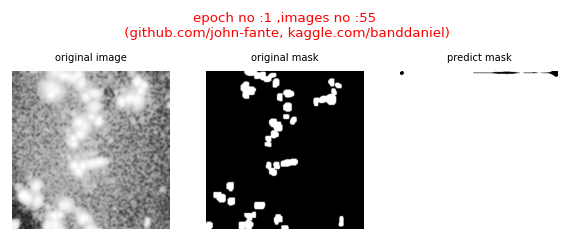

76/76 [==============================] - 71s 437ms/step - loss: 0.3391 - dice_coef_loss: 0.4127 - dice_coef: 0.5873 - jaccard: 0.4281 - accuracy: 0.8581 - val_loss: 1.7096 - val_dice_coef_loss: 0.6435 - val_dice_coef: 0.3565 - val_jaccard: 0.2188 - val_accuracy: 0.2202
Epoch 2/50
76/76 [==============================] - ETA: 0s - loss: 0.1727 - dice_coef_loss: 0.2686 - dice_coef: 0.7314 - jaccard: 0.5795 - accuracy: 0.9063

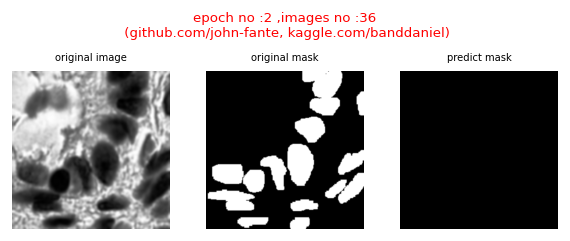

76/76 [==============================] - 33s 408ms/step - loss: 0.1727 - dice_coef_loss: 0.2686 - dice_coef: 0.7314 - jaccard: 0.5795 - accuracy: 0.9063 - val_loss: 0.8903 - val_dice_coef_loss: 0.9559 - val_dice_coef: 0.0441 - val_jaccard: 0.0226 - val_accuracy: 0.7561
Epoch 3/50
76/76 [==============================] - ETA: 0s - loss: 0.1473 - dice_coef_loss: 0.2274 - dice_coef: 0.7726 - jaccard: 0.6314 - accuracy: 0.9179

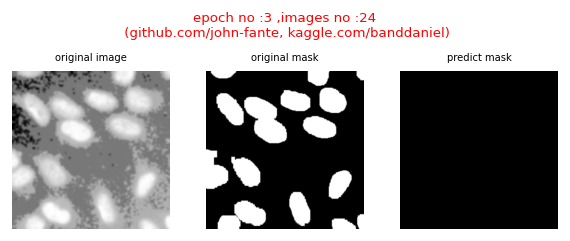

76/76 [==============================] - 33s 408ms/step - loss: 0.1473 - dice_coef_loss: 0.2274 - dice_coef: 0.7726 - jaccard: 0.6314 - accuracy: 0.9179 - val_loss: 0.7058 - val_dice_coef_loss: 0.9104 - val_dice_coef: 0.0896 - val_jaccard: 0.0469 - val_accuracy: 0.7561
Epoch 4/50
76/76 [==============================] - ETA: 0s - loss: 0.1304 - dice_coef_loss: 0.2012 - dice_coef: 0.7988 - jaccard: 0.6668 - accuracy: 0.9249

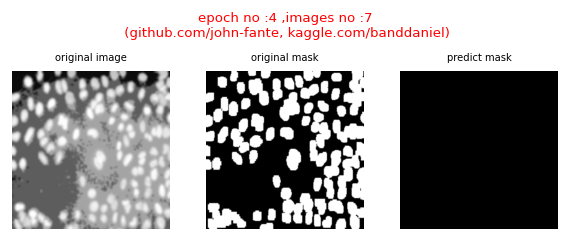

76/76 [==============================] - 32s 408ms/step - loss: 0.1304 - dice_coef_loss: 0.2012 - dice_coef: 0.7988 - jaccard: 0.6668 - accuracy: 0.9249 - val_loss: 2.1884 - val_dice_coef_loss: 0.9997 - val_dice_coef: 3.1078e-04 - val_jaccard: 1.5416e-04 - val_accuracy: 0.7561
Epoch 5/50
76/76 [==============================] - ETA: 0s - loss: 0.1221 - dice_coef_loss: 0.1873 - dice_coef: 0.8127 - jaccard: 0.6860 - accuracy: 0.9283

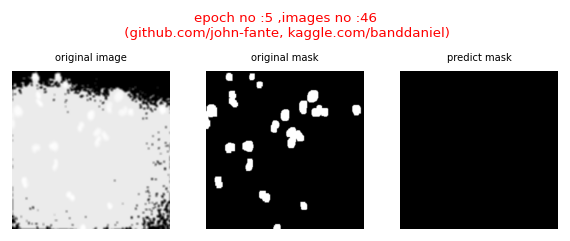

76/76 [==============================] - 33s 408ms/step - loss: 0.1221 - dice_coef_loss: 0.1873 - dice_coef: 0.8127 - jaccard: 0.6860 - accuracy: 0.9283 - val_loss: 1.0486 - val_dice_coef_loss: 0.9737 - val_dice_coef: 0.0263 - val_jaccard: 0.0133 - val_accuracy: 0.7561
Epoch 6/50
76/76 [==============================] - ETA: 0s - loss: 0.1135 - dice_coef_loss: 0.1750 - dice_coef: 0.8250 - jaccard: 0.7035 - accuracy: 0.9320

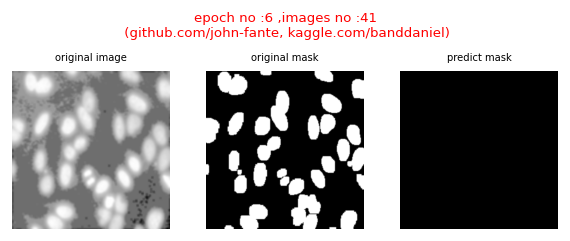

76/76 [==============================] - 32s 406ms/step - loss: 0.1135 - dice_coef_loss: 0.1750 - dice_coef: 0.8250 - jaccard: 0.7035 - accuracy: 0.9320 - val_loss: 2.5598 - val_dice_coef_loss: 0.9997 - val_dice_coef: 2.6277e-04 - val_jaccard: 1.3014e-04 - val_accuracy: 0.7561
Epoch 7/50
76/76 [==============================] - ETA: 0s - loss: 0.1201 - dice_coef_loss: 0.1858 - dice_coef: 0.8142 - jaccard: 0.6891 - accuracy: 0.9296

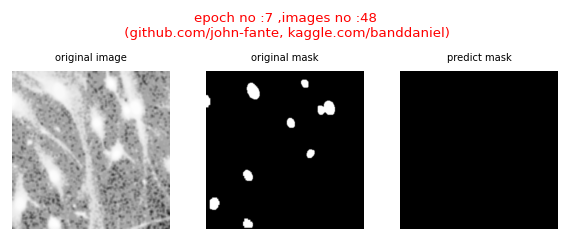

76/76 [==============================] - 32s 406ms/step - loss: 0.1201 - dice_coef_loss: 0.1858 - dice_coef: 0.8142 - jaccard: 0.6891 - accuracy: 0.9296 - val_loss: 2.7119 - val_dice_coef_loss: 0.9909 - val_dice_coef: 0.0091 - val_jaccard: 0.0046 - val_accuracy: 0.7566
Epoch 8/50
76/76 [==============================] - ETA: 0s - loss: 0.1014 - dice_coef_loss: 0.1546 - dice_coef: 0.8454 - jaccard: 0.7334 - accuracy: 0.9370

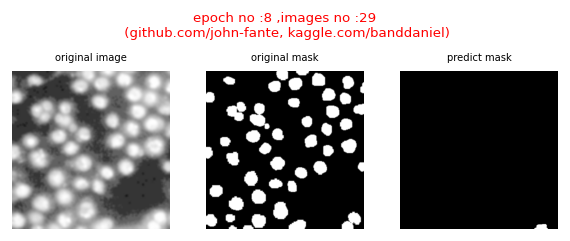

76/76 [==============================] - 32s 408ms/step - loss: 0.1014 - dice_coef_loss: 0.1546 - dice_coef: 0.8454 - jaccard: 0.7334 - accuracy: 0.9370 - val_loss: 0.8583 - val_dice_coef_loss: 0.8928 - val_dice_coef: 0.1072 - val_jaccard: 0.0572 - val_accuracy: 0.7590
Epoch 9/50
76/76 [==============================] - ETA: 0s - loss: 0.0926 - dice_coef_loss: 0.1441 - dice_coef: 0.8559 - jaccard: 0.7491 - accuracy: 0.9400

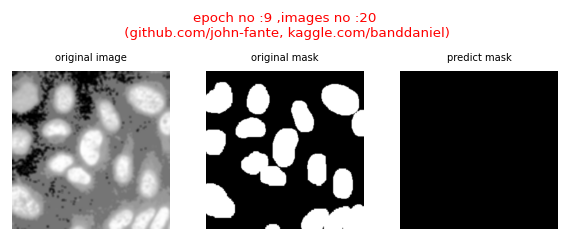

76/76 [==============================] - 32s 406ms/step - loss: 0.0926 - dice_coef_loss: 0.1441 - dice_coef: 0.8559 - jaccard: 0.7491 - accuracy: 0.9400 - val_loss: 1.9038 - val_dice_coef_loss: 0.9930 - val_dice_coef: 0.0070 - val_jaccard: 0.0035 - val_accuracy: 0.7562
Epoch 10/50
76/76 [==============================] - ETA: 0s - loss: 0.0895 - dice_coef_loss: 0.1385 - dice_coef: 0.8615 - jaccard: 0.7577 - accuracy: 0.9414

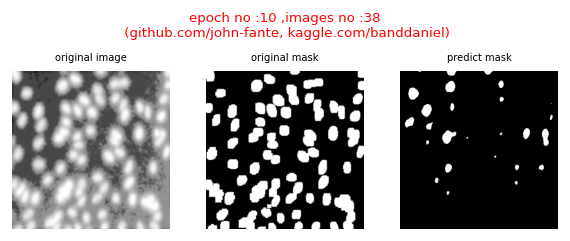

76/76 [==============================] - 33s 408ms/step - loss: 0.0895 - dice_coef_loss: 0.1385 - dice_coef: 0.8615 - jaccard: 0.7577 - accuracy: 0.9414 - val_loss: 0.8474 - val_dice_coef_loss: 0.7625 - val_dice_coef: 0.2375 - val_jaccard: 0.1379 - val_accuracy: 0.7796
Epoch 11/50
76/76 [==============================] - ETA: 0s - loss: 0.0890 - dice_coef_loss: 0.1365 - dice_coef: 0.8635 - jaccard: 0.7608 - accuracy: 0.9418

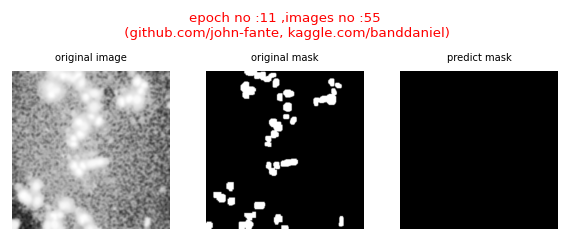

76/76 [==============================] - 32s 407ms/step - loss: 0.0890 - dice_coef_loss: 0.1365 - dice_coef: 0.8635 - jaccard: 0.7608 - accuracy: 0.9418 - val_loss: 0.8887 - val_dice_coef_loss: 0.8011 - val_dice_coef: 0.1989 - val_jaccard: 0.1159 - val_accuracy: 0.7778
Epoch 12/50
76/76 [==============================] - ETA: 0s - loss: 0.0837 - dice_coef_loss: 0.1308 - dice_coef: 0.8692 - jaccard: 0.7696 - accuracy: 0.9434

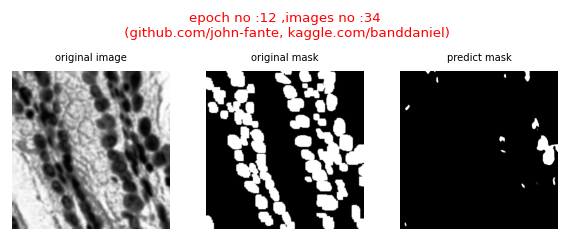

76/76 [==============================] - 32s 408ms/step - loss: 0.0837 - dice_coef_loss: 0.1308 - dice_coef: 0.8692 - jaccard: 0.7696 - accuracy: 0.9434 - val_loss: 0.4432 - val_dice_coef_loss: 0.4906 - val_dice_coef: 0.5094 - val_jaccard: 0.3515 - val_accuracy: 0.8333
Epoch 13/50
76/76 [==============================] - ETA: 0s - loss: 0.0748 - dice_coef_loss: 0.1159 - dice_coef: 0.8841 - jaccard: 0.7927 - accuracy: 0.9470

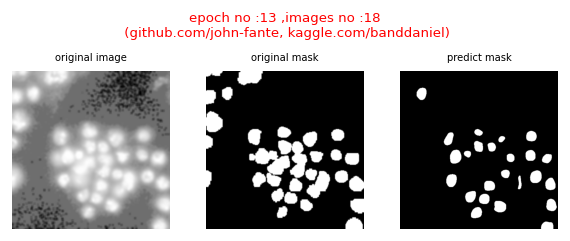

76/76 [==============================] - 33s 408ms/step - loss: 0.0748 - dice_coef_loss: 0.1159 - dice_coef: 0.8841 - jaccard: 0.7927 - accuracy: 0.9470 - val_loss: 0.7695 - val_dice_coef_loss: 0.5813 - val_dice_coef: 0.4187 - val_jaccard: 0.2758 - val_accuracy: 0.8168
Epoch 14/50
76/76 [==============================] - ETA: 0s - loss: 0.0676 - dice_coef_loss: 0.1048 - dice_coef: 0.8952 - jaccard: 0.8107 - accuracy: 0.9498

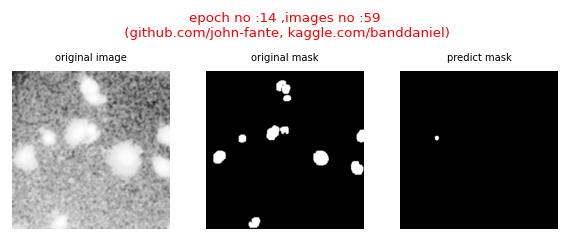

76/76 [==============================] - 33s 408ms/step - loss: 0.0676 - dice_coef_loss: 0.1048 - dice_coef: 0.8952 - jaccard: 0.8107 - accuracy: 0.9498 - val_loss: 0.3147 - val_dice_coef_loss: 0.2749 - val_dice_coef: 0.7251 - val_jaccard: 0.5744 - val_accuracy: 0.8904
Epoch 15/50
76/76 [==============================] - ETA: 0s - loss: 0.0662 - dice_coef_loss: 0.1028 - dice_coef: 0.8972 - jaccard: 0.8139 - accuracy: 0.9503

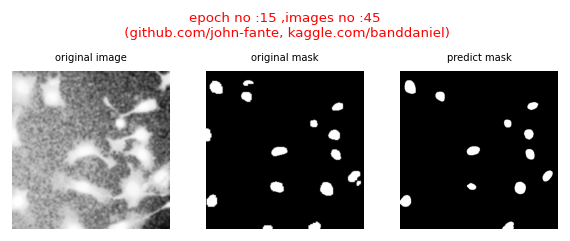

76/76 [==============================] - 33s 408ms/step - loss: 0.0662 - dice_coef_loss: 0.1028 - dice_coef: 0.8972 - jaccard: 0.8139 - accuracy: 0.9503 - val_loss: 0.1007 - val_dice_coef_loss: 0.1289 - val_dice_coef: 0.8711 - val_jaccard: 0.7727 - val_accuracy: 0.9383
Epoch 16/50
76/76 [==============================] - ETA: 0s - loss: 0.0615 - dice_coef_loss: 0.0956 - dice_coef: 0.9044 - jaccard: 0.8258 - accuracy: 0.9521

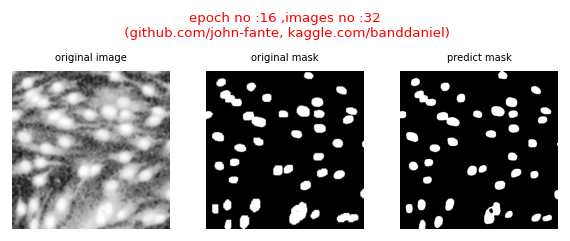

76/76 [==============================] - 33s 407ms/step - loss: 0.0615 - dice_coef_loss: 0.0956 - dice_coef: 0.9044 - jaccard: 0.8258 - accuracy: 0.9521 - val_loss: 0.0795 - val_dice_coef_loss: 0.1073 - val_dice_coef: 0.8927 - val_jaccard: 0.8068 - val_accuracy: 0.9438
Epoch 17/50
76/76 [==============================] - ETA: 0s - loss: 0.0614 - dice_coef_loss: 0.0952 - dice_coef: 0.9048 - jaccard: 0.8264 - accuracy: 0.9521

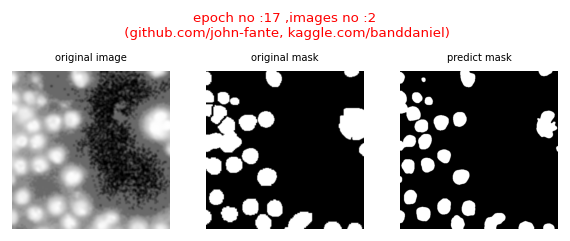

76/76 [==============================] - 33s 408ms/step - loss: 0.0614 - dice_coef_loss: 0.0952 - dice_coef: 0.9048 - jaccard: 0.8264 - accuracy: 0.9521 - val_loss: 0.0808 - val_dice_coef_loss: 0.1091 - val_dice_coef: 0.8909 - val_jaccard: 0.8038 - val_accuracy: 0.9430
Epoch 18/50
76/76 [==============================] - ETA: 0s - loss: 0.0578 - dice_coef_loss: 0.0898 - dice_coef: 0.9102 - jaccard: 0.8355 - accuracy: 0.9534

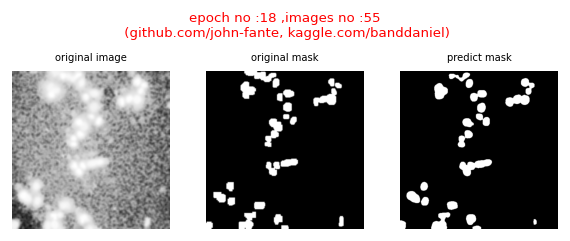

76/76 [==============================] - 33s 408ms/step - loss: 0.0578 - dice_coef_loss: 0.0898 - dice_coef: 0.9102 - jaccard: 0.8355 - accuracy: 0.9534 - val_loss: 0.0774 - val_dice_coef_loss: 0.1081 - val_dice_coef: 0.8919 - val_jaccard: 0.8053 - val_accuracy: 0.9444
Epoch 19/50
76/76 [==============================] - ETA: 0s - loss: 0.0578 - dice_coef_loss: 0.0900 - dice_coef: 0.9100 - jaccard: 0.8352 - accuracy: 0.9534

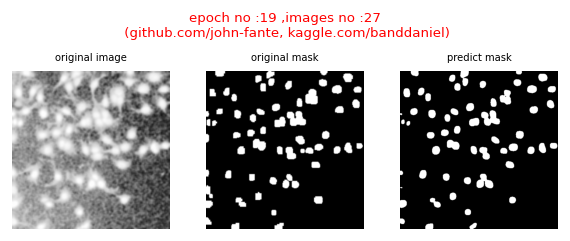

76/76 [==============================] - 34s 424ms/step - loss: 0.0578 - dice_coef_loss: 0.0900 - dice_coef: 0.9100 - jaccard: 0.8352 - accuracy: 0.9534 - val_loss: 0.0765 - val_dice_coef_loss: 0.1007 - val_dice_coef: 0.8993 - val_jaccard: 0.8174 - val_accuracy: 0.9451
Epoch 20/50
76/76 [==============================] - ETA: 0s - loss: 0.0582 - dice_coef_loss: 0.0906 - dice_coef: 0.9094 - jaccard: 0.8340 - accuracy: 0.9532

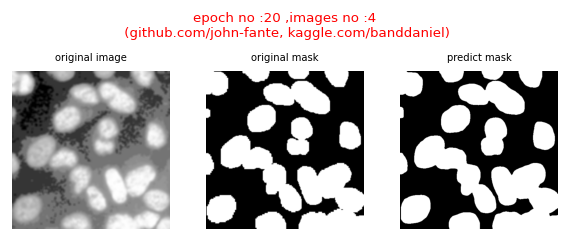

76/76 [==============================] - 33s 412ms/step - loss: 0.0582 - dice_coef_loss: 0.0906 - dice_coef: 0.9094 - jaccard: 0.8340 - accuracy: 0.9532 - val_loss: 0.0607 - val_dice_coef_loss: 0.0843 - val_dice_coef: 0.9157 - val_jaccard: 0.8448 - val_accuracy: 0.9506
Epoch 21/50
76/76 [==============================] - ETA: 0s - loss: 0.0542 - dice_coef_loss: 0.0848 - dice_coef: 0.9152 - jaccard: 0.8439 - accuracy: 0.9546

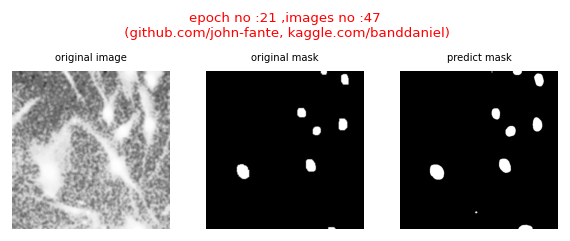

76/76 [==============================] - 33s 408ms/step - loss: 0.0542 - dice_coef_loss: 0.0848 - dice_coef: 0.9152 - jaccard: 0.8439 - accuracy: 0.9546 - val_loss: 0.0642 - val_dice_coef_loss: 0.0873 - val_dice_coef: 0.9127 - val_jaccard: 0.8396 - val_accuracy: 0.9490
Epoch 22/50
76/76 [==============================] - ETA: 0s - loss: 0.0529 - dice_coef_loss: 0.0823 - dice_coef: 0.9177 - jaccard: 0.8482 - accuracy: 0.9551

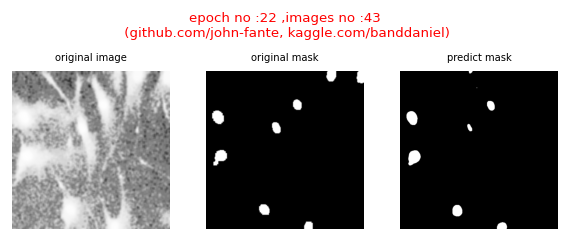

76/76 [==============================] - 33s 408ms/step - loss: 0.0529 - dice_coef_loss: 0.0823 - dice_coef: 0.9177 - jaccard: 0.8482 - accuracy: 0.9551 - val_loss: 0.0799 - val_dice_coef_loss: 0.1055 - val_dice_coef: 0.8945 - val_jaccard: 0.8096 - val_accuracy: 0.9440
Epoch 23/50
76/76 [==============================] - ETA: 0s - loss: 0.0554 - dice_coef_loss: 0.0869 - dice_coef: 0.9131 - jaccard: 0.8403 - accuracy: 0.9543

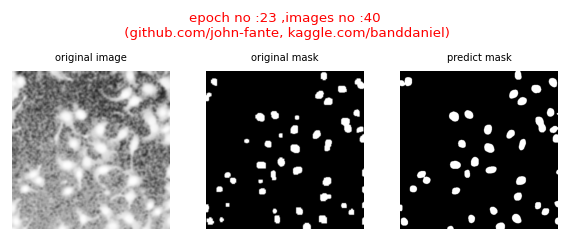

76/76 [==============================] - 33s 408ms/step - loss: 0.0554 - dice_coef_loss: 0.0869 - dice_coef: 0.9131 - jaccard: 0.8403 - accuracy: 0.9543 - val_loss: 0.0710 - val_dice_coef_loss: 0.1002 - val_dice_coef: 0.8998 - val_jaccard: 0.8180 - val_accuracy: 0.9468
Epoch 24/50
76/76 [==============================] - ETA: 0s - loss: 0.0520 - dice_coef_loss: 0.0809 - dice_coef: 0.9191 - jaccard: 0.8505 - accuracy: 0.9555

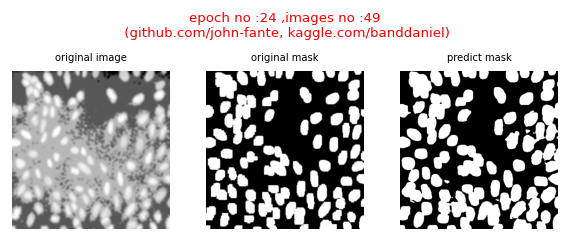

76/76 [==============================] - 33s 408ms/step - loss: 0.0520 - dice_coef_loss: 0.0809 - dice_coef: 0.9191 - jaccard: 0.8505 - accuracy: 0.9555 - val_loss: 0.0664 - val_dice_coef_loss: 0.0901 - val_dice_coef: 0.9099 - val_jaccard: 0.8350 - val_accuracy: 0.9483
Epoch 25/50
76/76 [==============================] - ETA: 0s - loss: 0.0518 - dice_coef_loss: 0.0815 - dice_coef: 0.9185 - jaccard: 0.8495 - accuracy: 0.9555

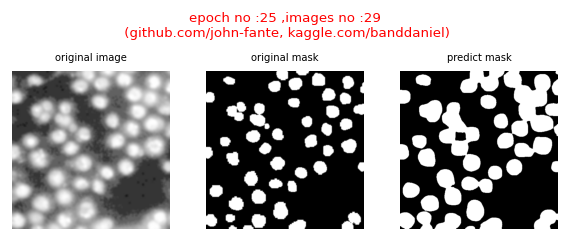

76/76 [==============================] - 33s 408ms/step - loss: 0.0518 - dice_coef_loss: 0.0815 - dice_coef: 0.9185 - jaccard: 0.8495 - accuracy: 0.9555 - val_loss: 0.0684 - val_dice_coef_loss: 0.0876 - val_dice_coef: 0.9124 - val_jaccard: 0.8390 - val_accuracy: 0.9478
Epoch 26/50
76/76 [==============================] - ETA: 0s - loss: 0.0631 - dice_coef_loss: 0.0969 - dice_coef: 0.9031 - jaccard: 0.8238 - accuracy: 0.9515

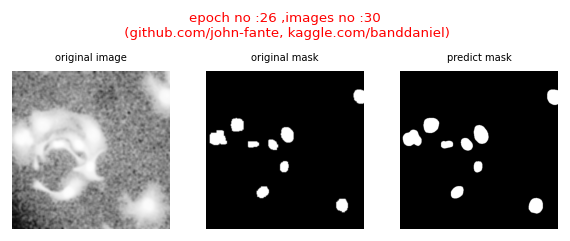

76/76 [==============================] - 33s 408ms/step - loss: 0.0631 - dice_coef_loss: 0.0969 - dice_coef: 0.9031 - jaccard: 0.8238 - accuracy: 0.9515 - val_loss: 0.0753 - val_dice_coef_loss: 0.1060 - val_dice_coef: 0.8940 - val_jaccard: 0.8086 - val_accuracy: 0.9450
Epoch 27/50
76/76 [==============================] - ETA: 0s - loss: 0.0590 - dice_coef_loss: 0.0922 - dice_coef: 0.9078 - jaccard: 0.8315 - accuracy: 0.9529

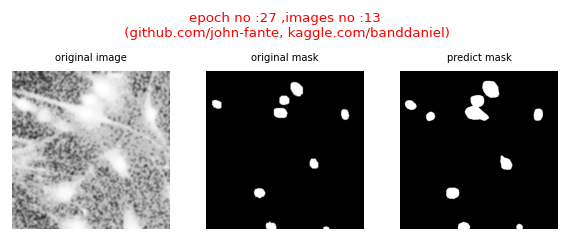

76/76 [==============================] - 33s 408ms/step - loss: 0.0590 - dice_coef_loss: 0.0922 - dice_coef: 0.9078 - jaccard: 0.8315 - accuracy: 0.9529 - val_loss: 0.0865 - val_dice_coef_loss: 0.1183 - val_dice_coef: 0.8817 - val_jaccard: 0.7889 - val_accuracy: 0.9405
Epoch 28/50
76/76 [==============================] - ETA: 0s - loss: 0.0583 - dice_coef_loss: 0.0909 - dice_coef: 0.9091 - jaccard: 0.8338 - accuracy: 0.9531

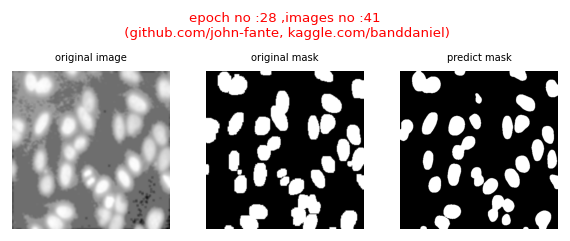

76/76 [==============================] - 32s 407ms/step - loss: 0.0583 - dice_coef_loss: 0.0909 - dice_coef: 0.9091 - jaccard: 0.8338 - accuracy: 0.9531 - val_loss: 0.3197 - val_dice_coef_loss: 0.3048 - val_dice_coef: 0.6952 - val_jaccard: 0.5354 - val_accuracy: 0.8790
Epoch 29/50
76/76 [==============================] - ETA: 0s - loss: 0.0608 - dice_coef_loss: 0.0942 - dice_coef: 0.9058 - jaccard: 0.8282 - accuracy: 0.9524

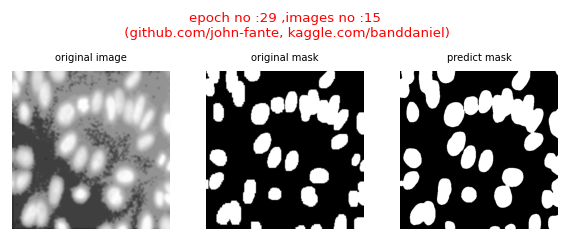

76/76 [==============================] - 33s 416ms/step - loss: 0.0608 - dice_coef_loss: 0.0942 - dice_coef: 0.9058 - jaccard: 0.8282 - accuracy: 0.9524 - val_loss: 0.1178 - val_dice_coef_loss: 0.1352 - val_dice_coef: 0.8648 - val_jaccard: 0.7627 - val_accuracy: 0.9308
Epoch 30/50
76/76 [==============================] - ETA: 0s - loss: 0.0562 - dice_coef_loss: 0.0883 - dice_coef: 0.9117 - jaccard: 0.8379 - accuracy: 0.9539

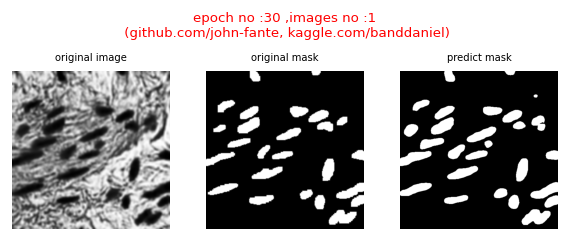

76/76 [==============================] - 33s 408ms/step - loss: 0.0562 - dice_coef_loss: 0.0883 - dice_coef: 0.9117 - jaccard: 0.8379 - accuracy: 0.9539 - val_loss: 0.0589 - val_dice_coef_loss: 0.0828 - val_dice_coef: 0.9172 - val_jaccard: 0.8474 - val_accuracy: 0.9508
Epoch 31/50
76/76 [==============================] - ETA: 0s - loss: 0.0481 - dice_coef_loss: 0.0750 - dice_coef: 0.9250 - jaccard: 0.8607 - accuracy: 0.9568

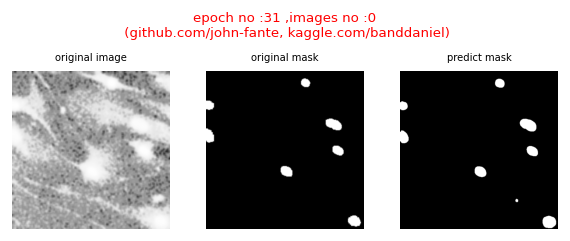

76/76 [==============================] - 33s 408ms/step - loss: 0.0481 - dice_coef_loss: 0.0750 - dice_coef: 0.9250 - jaccard: 0.8607 - accuracy: 0.9568 - val_loss: 0.0527 - val_dice_coef_loss: 0.0730 - val_dice_coef: 0.9270 - val_jaccard: 0.8640 - val_accuracy: 0.9534
Epoch 32/50
76/76 [==============================] - ETA: 0s - loss: 0.0451 - dice_coef_loss: 0.0704 - dice_coef: 0.9296 - jaccard: 0.8686 - accuracy: 0.9578

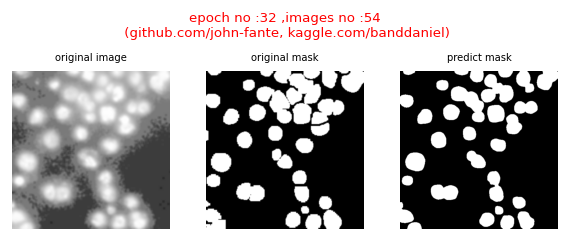

76/76 [==============================] - 33s 407ms/step - loss: 0.0451 - dice_coef_loss: 0.0704 - dice_coef: 0.9296 - jaccard: 0.8686 - accuracy: 0.9578 - val_loss: 0.0544 - val_dice_coef_loss: 0.0718 - val_dice_coef: 0.9282 - val_jaccard: 0.8662 - val_accuracy: 0.9530
Epoch 33/50
76/76 [==============================] - ETA: 0s - loss: 0.0436 - dice_coef_loss: 0.0680 - dice_coef: 0.9320 - jaccard: 0.8728 - accuracy: 0.9584

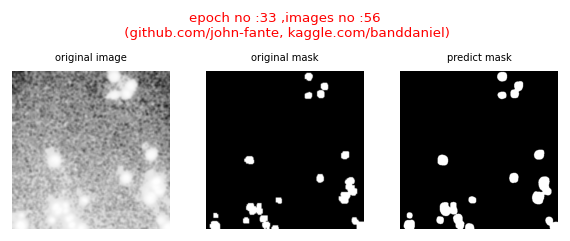

76/76 [==============================] - 33s 407ms/step - loss: 0.0436 - dice_coef_loss: 0.0680 - dice_coef: 0.9320 - jaccard: 0.8728 - accuracy: 0.9584 - val_loss: 0.0581 - val_dice_coef_loss: 0.0760 - val_dice_coef: 0.9240 - val_jaccard: 0.8590 - val_accuracy: 0.9515
Epoch 34/50
76/76 [==============================] - ETA: 0s - loss: 0.0433 - dice_coef_loss: 0.0677 - dice_coef: 0.9323 - jaccard: 0.8733 - accuracy: 0.9584

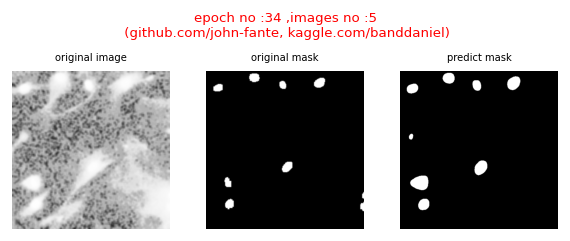

76/76 [==============================] - 33s 407ms/step - loss: 0.0433 - dice_coef_loss: 0.0677 - dice_coef: 0.9323 - jaccard: 0.8733 - accuracy: 0.9584 - val_loss: 0.0599 - val_dice_coef_loss: 0.0800 - val_dice_coef: 0.9200 - val_jaccard: 0.8521 - val_accuracy: 0.9511
Epoch 35/50
76/76 [==============================] - ETA: 0s - loss: 0.0445 - dice_coef_loss: 0.0698 - dice_coef: 0.9302 - jaccard: 0.8697 - accuracy: 0.9581

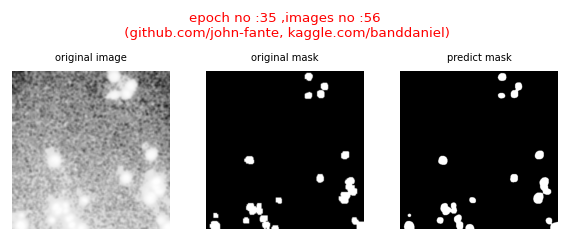

76/76 [==============================] - 33s 408ms/step - loss: 0.0445 - dice_coef_loss: 0.0698 - dice_coef: 0.9302 - jaccard: 0.8697 - accuracy: 0.9581 - val_loss: 0.0465 - val_dice_coef_loss: 0.0648 - val_dice_coef: 0.9352 - val_jaccard: 0.8785 - val_accuracy: 0.9554
Epoch 36/50
76/76 [==============================] - ETA: 0s - loss: 0.0431 - dice_coef_loss: 0.0673 - dice_coef: 0.9327 - jaccard: 0.8740 - accuracy: 0.9586

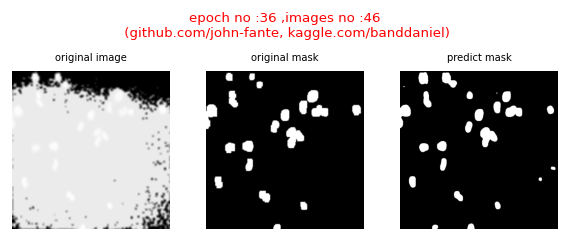

76/76 [==============================] - 33s 408ms/step - loss: 0.0431 - dice_coef_loss: 0.0673 - dice_coef: 0.9327 - jaccard: 0.8740 - accuracy: 0.9586 - val_loss: 0.0496 - val_dice_coef_loss: 0.0659 - val_dice_coef: 0.9341 - val_jaccard: 0.8765 - val_accuracy: 0.9547
Epoch 37/50
76/76 [==============================] - ETA: 0s - loss: 0.0403 - dice_coef_loss: 0.0631 - dice_coef: 0.9369 - jaccard: 0.8814 - accuracy: 0.9594

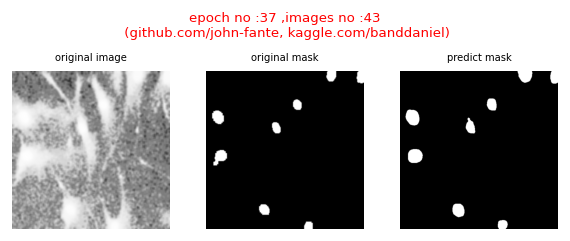

76/76 [==============================] - 32s 407ms/step - loss: 0.0403 - dice_coef_loss: 0.0631 - dice_coef: 0.9369 - jaccard: 0.8814 - accuracy: 0.9594 - val_loss: 0.0584 - val_dice_coef_loss: 0.0744 - val_dice_coef: 0.9256 - val_jaccard: 0.8616 - val_accuracy: 0.9516
Epoch 38/50
76/76 [==============================] - ETA: 0s - loss: 0.0394 - dice_coef_loss: 0.0618 - dice_coef: 0.9382 - jaccard: 0.8838 - accuracy: 0.9597

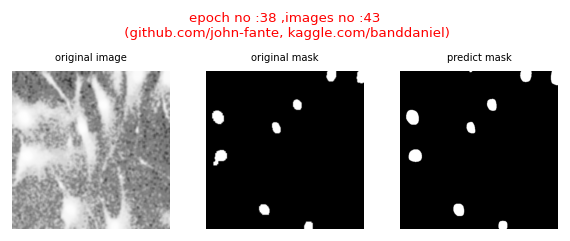

76/76 [==============================] - 33s 408ms/step - loss: 0.0394 - dice_coef_loss: 0.0618 - dice_coef: 0.9382 - jaccard: 0.8838 - accuracy: 0.9597 - val_loss: 0.0533 - val_dice_coef_loss: 0.0677 - val_dice_coef: 0.9323 - val_jaccard: 0.8733 - val_accuracy: 0.9536
Epoch 39/50
76/76 [==============================] - ETA: 0s - loss: 0.0390 - dice_coef_loss: 0.0609 - dice_coef: 0.9391 - jaccard: 0.8853 - accuracy: 0.9599

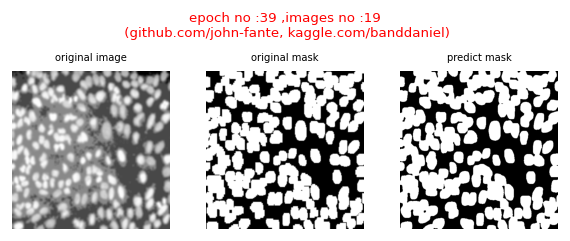

76/76 [==============================] - 33s 408ms/step - loss: 0.0390 - dice_coef_loss: 0.0609 - dice_coef: 0.9391 - jaccard: 0.8853 - accuracy: 0.9599 - val_loss: 0.0480 - val_dice_coef_loss: 0.0637 - val_dice_coef: 0.9363 - val_jaccard: 0.8804 - val_accuracy: 0.9551
Epoch 40/50
76/76 [==============================] - ETA: 0s - loss: 0.0388 - dice_coef_loss: 0.0609 - dice_coef: 0.9391 - jaccard: 0.8853 - accuracy: 0.9599

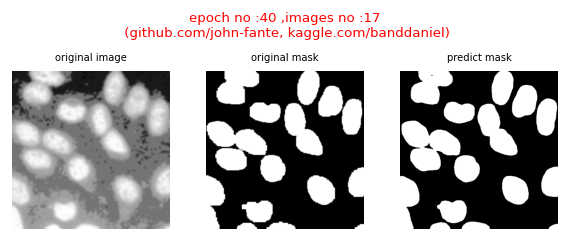

76/76 [==============================] - 33s 408ms/step - loss: 0.0388 - dice_coef_loss: 0.0609 - dice_coef: 0.9391 - jaccard: 0.8853 - accuracy: 0.9599 - val_loss: 0.0491 - val_dice_coef_loss: 0.0624 - val_dice_coef: 0.9376 - val_jaccard: 0.8827 - val_accuracy: 0.9550
Epoch 41/50
76/76 [==============================] - ETA: 0s - loss: 0.0392 - dice_coef_loss: 0.0613 - dice_coef: 0.9387 - jaccard: 0.8847 - accuracy: 0.9598

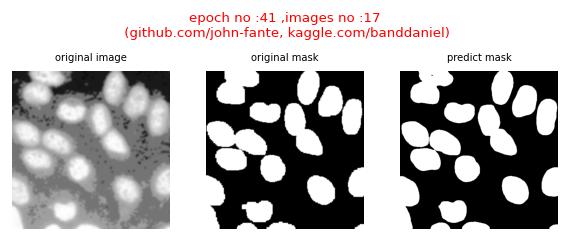

76/76 [==============================] - 33s 408ms/step - loss: 0.0392 - dice_coef_loss: 0.0613 - dice_coef: 0.9387 - jaccard: 0.8847 - accuracy: 0.9598 - val_loss: 0.0524 - val_dice_coef_loss: 0.0678 - val_dice_coef: 0.9322 - val_jaccard: 0.8731 - val_accuracy: 0.9538
Epoch 42/50
76/76 [==============================] - ETA: 0s - loss: 0.0394 - dice_coef_loss: 0.0618 - dice_coef: 0.9382 - jaccard: 0.8837 - accuracy: 0.9597

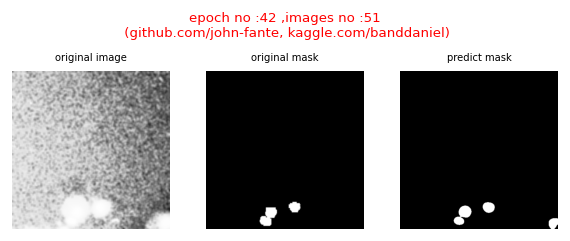

76/76 [==============================] - 32s 406ms/step - loss: 0.0394 - dice_coef_loss: 0.0618 - dice_coef: 0.9382 - jaccard: 0.8837 - accuracy: 0.9597 - val_loss: 0.0493 - val_dice_coef_loss: 0.0641 - val_dice_coef: 0.9359 - val_jaccard: 0.8797 - val_accuracy: 0.9548
Epoch 43/50
76/76 [==============================] - ETA: 0s - loss: 0.0408 - dice_coef_loss: 0.0639 - dice_coef: 0.9361 - jaccard: 0.8800 - accuracy: 0.9593

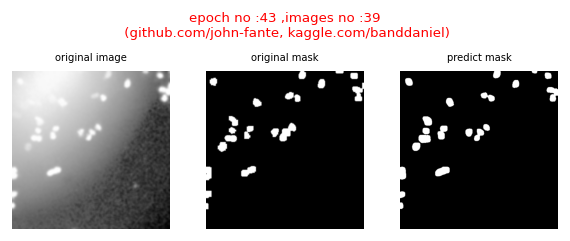

76/76 [==============================] - 33s 408ms/step - loss: 0.0408 - dice_coef_loss: 0.0639 - dice_coef: 0.9361 - jaccard: 0.8800 - accuracy: 0.9593 - val_loss: 0.0479 - val_dice_coef_loss: 0.0640 - val_dice_coef: 0.9360 - val_jaccard: 0.8798 - val_accuracy: 0.9551
Epoch 44/50
76/76 [==============================] - ETA: 0s - loss: 0.0392 - dice_coef_loss: 0.0611 - dice_coef: 0.9389 - jaccard: 0.8850 - accuracy: 0.9598

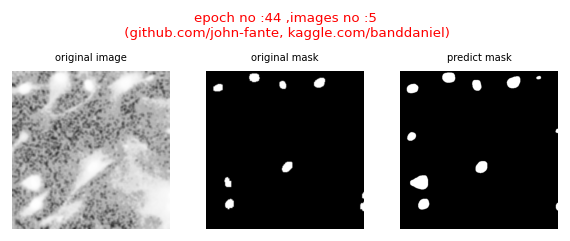

76/76 [==============================] - 33s 408ms/step - loss: 0.0392 - dice_coef_loss: 0.0611 - dice_coef: 0.9389 - jaccard: 0.8850 - accuracy: 0.9598 - val_loss: 0.0546 - val_dice_coef_loss: 0.0678 - val_dice_coef: 0.9322 - val_jaccard: 0.8731 - val_accuracy: 0.9531
Epoch 45/50
76/76 [==============================] - ETA: 0s - loss: 0.0386 - dice_coef_loss: 0.0604 - dice_coef: 0.9396 - jaccard: 0.8861 - accuracy: 0.9600

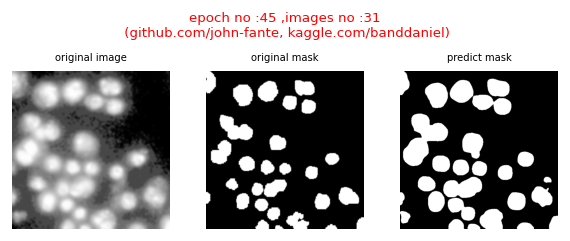

76/76 [==============================] - 33s 409ms/step - loss: 0.0386 - dice_coef_loss: 0.0604 - dice_coef: 0.9396 - jaccard: 0.8861 - accuracy: 0.9600 - val_loss: 0.0446 - val_dice_coef_loss: 0.0595 - val_dice_coef: 0.9405 - val_jaccard: 0.8879 - val_accuracy: 0.9562
Epoch 46/50
76/76 [==============================] - ETA: 0s - loss: 0.0383 - dice_coef_loss: 0.0599 - dice_coef: 0.9401 - jaccard: 0.8871 - accuracy: 0.9601

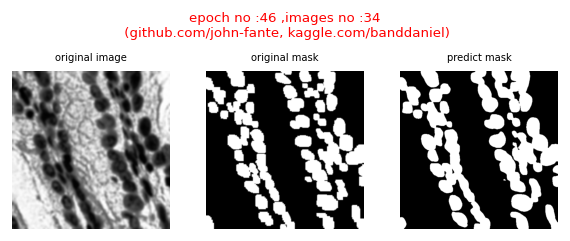

76/76 [==============================] - 33s 409ms/step - loss: 0.0383 - dice_coef_loss: 0.0599 - dice_coef: 0.9401 - jaccard: 0.8871 - accuracy: 0.9601 - val_loss: 0.0444 - val_dice_coef_loss: 0.0587 - val_dice_coef: 0.9413 - val_jaccard: 0.8893 - val_accuracy: 0.9563
Epoch 47/50
76/76 [==============================] - ETA: 0s - loss: 0.0380 - dice_coef_loss: 0.0594 - dice_coef: 0.9406 - jaccard: 0.8880 - accuracy: 0.9602

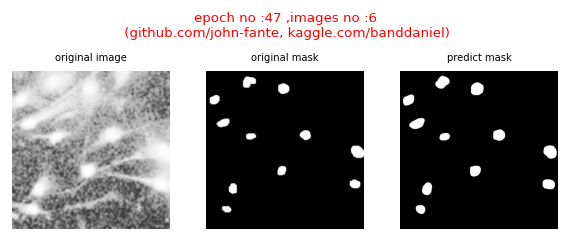

76/76 [==============================] - 33s 408ms/step - loss: 0.0380 - dice_coef_loss: 0.0594 - dice_coef: 0.9406 - jaccard: 0.8880 - accuracy: 0.9602 - val_loss: 0.0512 - val_dice_coef_loss: 0.0660 - val_dice_coef: 0.9340 - val_jaccard: 0.8763 - val_accuracy: 0.9541
Epoch 48/50
76/76 [==============================] - ETA: 0s - loss: 0.0379 - dice_coef_loss: 0.0594 - dice_coef: 0.9406 - jaccard: 0.8880 - accuracy: 0.9601

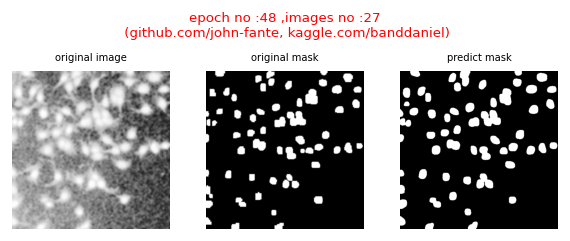

76/76 [==============================] - 33s 408ms/step - loss: 0.0379 - dice_coef_loss: 0.0594 - dice_coef: 0.9406 - jaccard: 0.8880 - accuracy: 0.9601 - val_loss: 0.0487 - val_dice_coef_loss: 0.0678 - val_dice_coef: 0.9322 - val_jaccard: 0.8731 - val_accuracy: 0.9547
Epoch 49/50
76/76 [==============================] - ETA: 0s - loss: 0.0378 - dice_coef_loss: 0.0597 - dice_coef: 0.9403 - jaccard: 0.8875 - accuracy: 0.9602

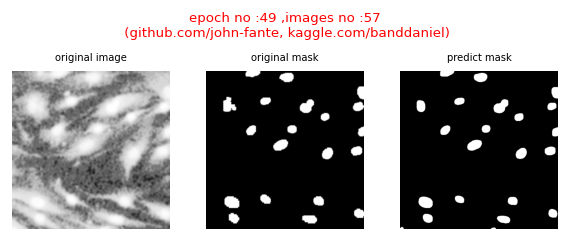

76/76 [==============================] - 33s 408ms/step - loss: 0.0378 - dice_coef_loss: 0.0597 - dice_coef: 0.9403 - jaccard: 0.8875 - accuracy: 0.9602 - val_loss: 0.0495 - val_dice_coef_loss: 0.0651 - val_dice_coef: 0.9349 - val_jaccard: 0.8779 - val_accuracy: 0.9547
Epoch 50/50
76/76 [==============================] - ETA: 0s - loss: 0.0377 - dice_coef_loss: 0.0591 - dice_coef: 0.9409 - jaccard: 0.8886 - accuracy: 0.9603

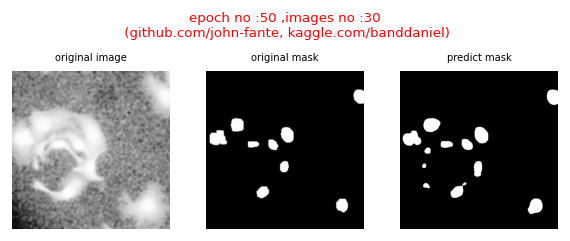

76/76 [==============================] - 33s 408ms/step - loss: 0.0377 - dice_coef_loss: 0.0591 - dice_coef: 0.9409 - jaccard: 0.8886 - accuracy: 0.9603 - val_loss: 0.0441 - val_dice_coef_loss: 0.0593 - val_dice_coef: 0.9407 - val_jaccard: 0.8881 - val_accuracy: 0.9564


In [37]:
hist = model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 50, validation_data = validation_dataset, callbacks = my_callbacks)

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation

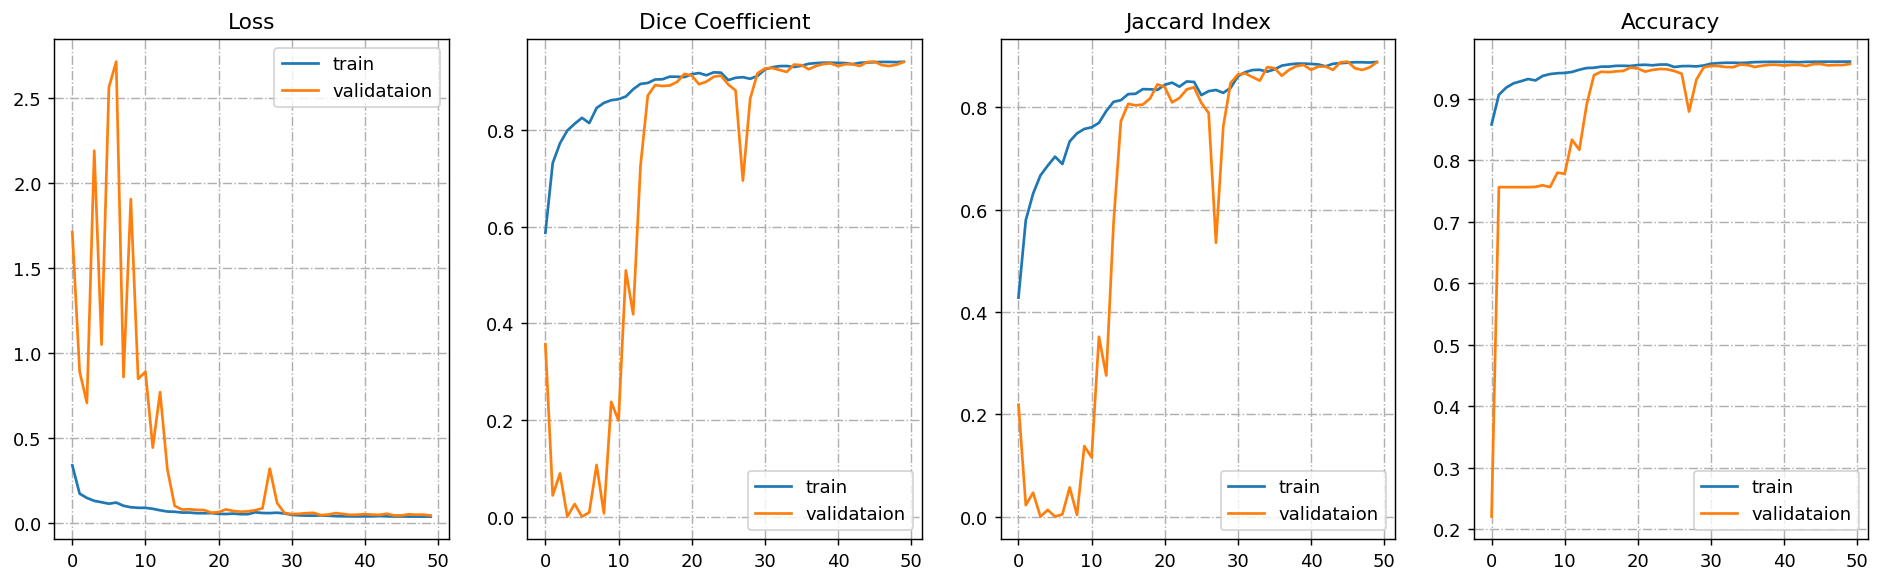

In [39]:
fig, axs = plt.subplots(1,4, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient")
axs[1].plot(hist.history['dice_coef'])
axs[1].plot(hist.history['val_dice_coef'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Jaccard Index")
axs[2].plot(hist.history['jaccard'])
axs[2].plot(hist.history['val_jaccard'])
axs[2].legend(["train",  "validataion"])

axs[3].grid(linestyle="dashdot")
axs[3].set_title("Accuracy")
axs[3].plot(hist.history['accuracy'])
axs[3].plot(hist.history['val_accuracy'])
axs[3].legend(["train",  "validataion"])


# <span style="color:#e74c3c;"> Test and Validation </span> Evaluation

In [40]:
val_eval = model.evaluate(validation_dataset)
test_eval = model.evaluate(test_dataset)

9/9 [==============================] - 1s 107ms/step - loss: 0.1251 - dice_coef_loss: 0.1098 - dice_coef: 0.8902 - jaccard: 0.8029 - accuracy: 0.9412


# <span style="color:#e74c3c;"> Test </span> Predictions

In [41]:
test_take1 =  validation_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())
    
pred_ = np.squeeze(pred)

threshold_1  = 0.3 #threshold for prediction
bitmap_pred_1 = (pred_ > threshold_1).astype(np.uint8)

threshold_2  = 0.99 #threshold for prediction
bitmap_pred_2 = (pred_ > threshold_2).astype(np.uint8)

12/12 [==============================] - 2s 108ms/step


In [42]:
# A function that calculating dice and jaccard metrics for prediction
def calc_dice_jaccard_for_prediction(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = tf.cast(y_true_f, tf.uint16)
    y_pred_f = tf.cast(y_pred_f, tf.uint16)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)
    
    return dice.numpy(),jaccard.numpy()


# A function that creating 3 random images in the test set and prediction it
def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(y_test_take))[:3]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

   
    fig, axs = plt.subplots(3,4, figsize = (10, 10 ) ,dpi = 150)
    
    for i in range(3):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        mask = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_mask_1 = bitmap_pred_1[idx[i]]
        pred_mask_2 = bitmap_pred_2[idx[i]]
        
        dice1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[0]
        jac1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[1]
        
        dice2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[0]
        jac2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[1]
        

        axs[i][0].imshow(image , cmap = 'gray')
        axs[i][0].axis('off')
        axs[i][0].set_title('original image (no: ' + str(idxs[i]) + ")", fontsize = 6)

        axs[i][1].imshow(mask, cmap = 'gray')
        axs[i][1].axis('off')
        axs[i][1].set_title('original mask', fontsize = 6)

        axs[i][2].imshow(pred_mask_1 , cmap = 'gray')
        axs[i][2].axis('off')
        axs[i][2].set_title('pred mask (0.3 threshold)'
                            + '\n Dice Coef: {0:0.3f}'.format(dice1) 
                            + '\n Jaccard Coef: {0:0.3f}'.format(jac1), color = 'red', fontsize = 6)
    
        axs[i][3].imshow(pred_mask_2 , cmap = 'gray')
        axs[i][3].axis('off')
        axs[i][3].set_title('pred mask (0.99 threshold)' + '\n Dice Coef: {0:0.3f}'.format(dice2) + '\n Jaccard Coef: {0:0.3f}'.format(jac2), color = 'red', fontsize = 6)

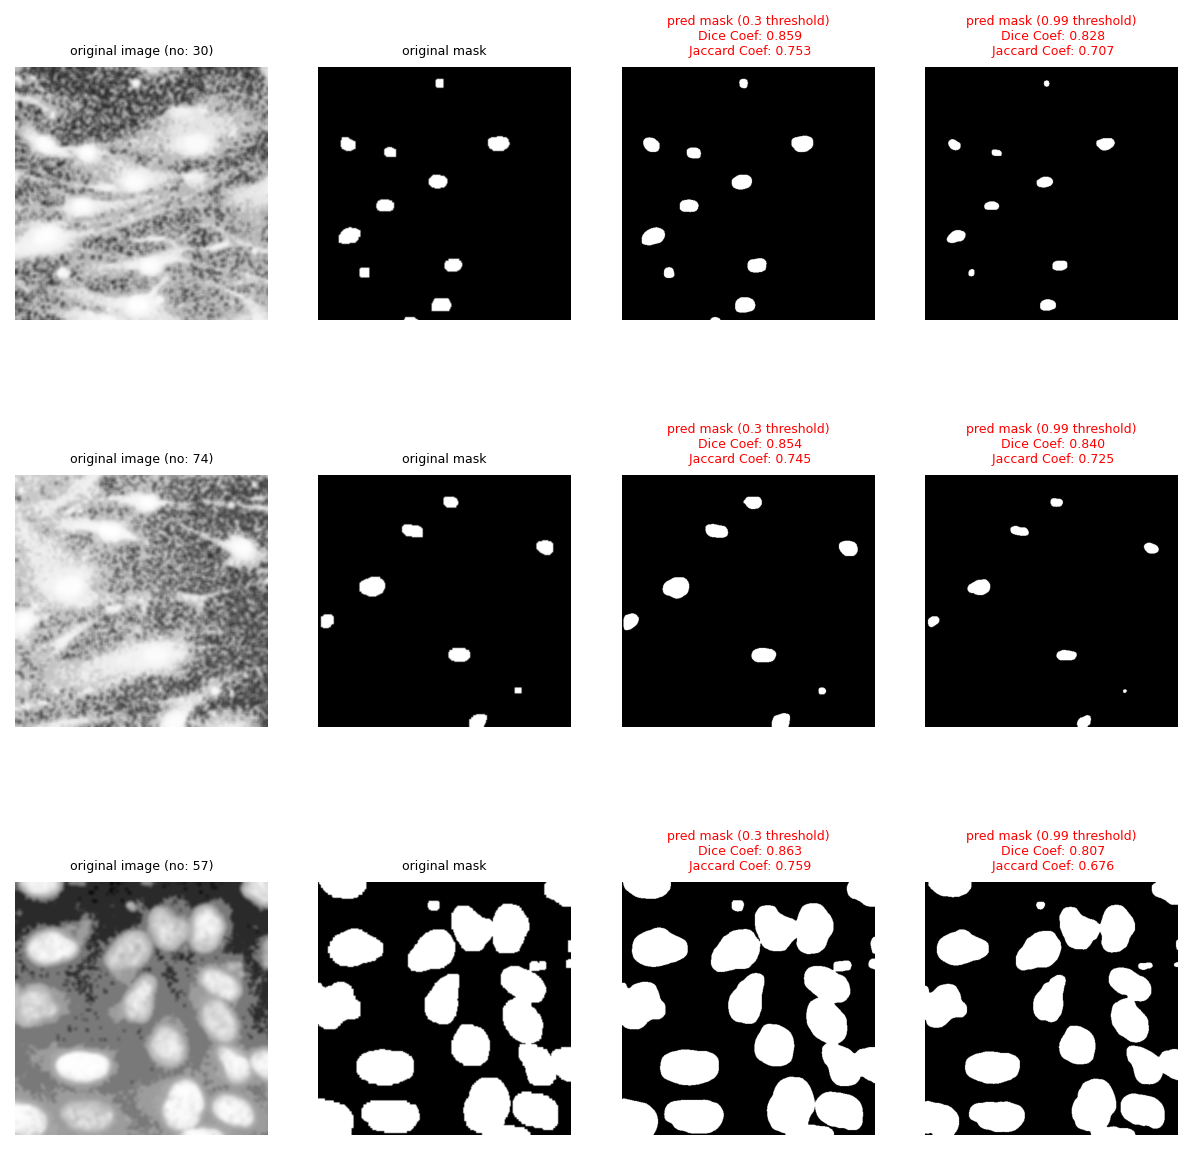

In [43]:
random_test_sample_with_prediction()